In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

In [4]:
vl.__version__

'0.0.11-py36_0'

In [5]:
innov_dim = 250

## Load the data

In [6]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 252
    vol = store['discrete_vol_est'] * 252**2 
    
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol']

In [7]:
data.head()

,rtn,vol
2003-01-02,6.419615,8.799756
2003-01-03,0.539956,7.785992
2003-01-06,5.150512,4.586335
2003-01-07,-0.896750,8.294531
2003-01-08,-2.748119,6.446751


In [8]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,rtn,vol
rtn,5.523276,-0.229847
vol,-0.229847,1.886587


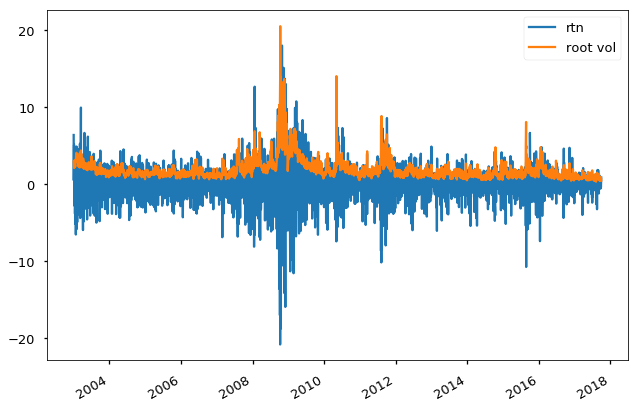

In [9]:
fig1, ax1 = mpl.pyplot.subplots()
data['rtn'].plot(ax=ax1)
data['vol'].apply(np.sqrt).plot(ax=ax1, label='root vol')
ax1.legend()

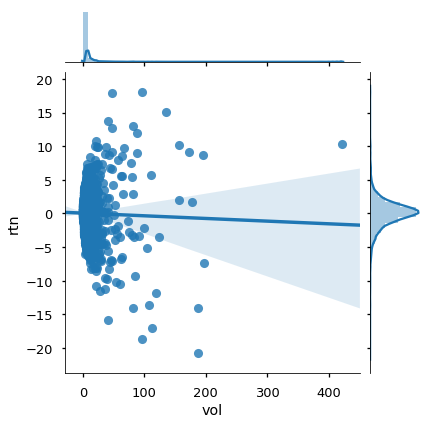

In [10]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [11]:
omega, omega_cov = vl.estimate_params_strong_id(data)

In [12]:
omega

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'delta': 0.2678579804909869,
 'rho': 0.8075059188831978,
 'scale': 3.1120129274168016,
 'phi': -0.3021332298877708,
 'pi': -0.35969605398014043,
 'theta': 0.5278630825503945}

In [13]:
omega_cov

,beta,delta,gamma,phi,pi,psi,rho,scale,theta,zeta
beta,0.000097,0.000000,-0.000035,NaN,NaN,-0.000091,0.000000,0.000000,NaN,0.000000
delta,0.000000,1.953968,0.000000,NaN,NaN,0.000000,-0.275013,-2.536490,NaN,0.000000
gamma,-0.000035,0.000000,0.000648,NaN,NaN,-0.000080,0.000000,0.000000,NaN,0.000000
phi,NaN,NaN,NaN,9.592997,-2.714527,NaN,NaN,NaN,4.126216,NaN
pi,NaN,NaN,NaN,-2.714527,0.781588,NaN,NaN,NaN,-1.164330,NaN
psi,-0.000091,0.000000,-0.000080,NaN,NaN,0.000149,0.000000,0.000000,NaN,0.000000
rho,0.000000,-0.275013,0.000000,NaN,NaN,0.000000,0.042748,0.326903,NaN,0.000000
scale,0.000000,-2.536490,0.000000,NaN,NaN,0.000000,0.326903,4.739982,NaN,0.000000
theta,NaN,NaN,NaN,4.126216,-1.164330,NaN,NaN,NaN,1.775765,NaN
zeta,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000431


In [14]:
data.vol.sort_values(ascending=True).head()

2017-08-07    0.123335
2017-09-14    0.214673
2017-09-22    0.216867
2016-11-25    0.226227
2017-07-24    0.242692
Name: vol, dtype: float64

In [15]:
omega2, omega_cov2 = vl.estimate_params(data)

In [49]:
qlr_stats = vl.compute_qlr_stats(omega=omega2, omega_cov=omega_cov2, theta_dim=10, pi_dim=10, phi_dim=10, 
                                 pi_min=-.25, pi_max=0, theta_min=.2, theta_max=.6,  use_tqdm=True)
                               


In [17]:
omega2

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'delta': 0.2678579804909869,
 'rho': 0.8075059188831978,
 'scale': 3.1120129274168016}

In [18]:
qlr_draws = vl.compute_qlr_sim(omega=omega2, omega_cov=omega_cov2, theta_dim=10, pi_dim=10, phi_dim=10, 
                               innov_dim=innov_dim, pi_min=-.25, pi_max=0, theta_min=.2, theta_max=.6,
                               use_tqdm=True, alpha=0.05)

In [42]:
qlr_draws[(qlr_draws['phi'] >= -0.39) & (qlr_draws['phi'] <= -0.2)].query('pi >= 0')

,phi,pi,theta,qlr
690,-0.3,0.0,0.200000,5.493526
691,-0.3,0.0,0.244444,6.504648
692,-0.3,0.0,0.377778,6.809761
693,-0.3,0.0,0.288889,5.496399
694,-0.3,0.0,0.333333,6.460130
695,-0.3,0.0,0.422222,6.690057
696,-0.3,0.0,0.466667,7.480246
697,-0.3,0.0,0.511111,6.436023
698,-0.3,0.0,0.555556,7.464977
699,-0.3,0.0,0.600000,6.969756


In [48]:
qlr_draws[np.isclose(qlr_draws.phi, -0.3)][qlr_draws['qlr'] > 0].sort_values(by='qlr').head(20)

,phi,pi,theta,qlr
690,-0.3,0.000000,0.200000,5.493526
693,-0.3,0.000000,0.288889,5.496399
681,-0.3,-0.027778,0.288889,5.522238
660,-0.3,-0.083333,0.333333,6.086173
666,-0.3,-0.083333,0.244444,6.185144
656,-0.3,-0.111111,0.377778,6.266195
614,-0.3,-0.250000,0.600000,6.278101
653,-0.3,-0.111111,0.333333,6.282174
680,-0.3,-0.027778,0.200000,6.348894
682,-0.3,-0.027778,0.244444,6.366298


In [50]:
qlr_stats.sort_values(by='qlr')

,phi,pi,theta,qlr
657,-0.3,-0.111111,0.511111,0.041189
648,-0.3,-0.138889,0.555556,1.399743
686,-0.3,-0.027778,0.466667,2.241040
604,-0.3,-0.250000,0.511111,2.278916
667,-0.3,-0.083333,0.511111,2.302626
617,-0.3,-0.222222,0.466667,3.086692
677,-0.3,-0.055556,0.466667,3.092439
647,-0.3,-0.138889,0.511111,3.590907
696,-0.3,0.000000,0.466667,3.786496
605,-0.3,-0.250000,0.466667,4.428556


In [51]:
qlr_draws.to_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region.json')

In [52]:
accepted_vals = pd.merge(qlr_draws, qlr_stats, right_on=['phi', 'pi', 'theta'], left_on=['phi', 'pi', 'theta'],
         how='outer', suffixes=['_draws', '_stats']).query('qlr_stats < qlr_draws').drop(
    ['qlr_draws', 'qlr_stats'], axis='columns')

In [53]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

In [54]:
accepted_vals

,phi,pi,theta
606,-0.3,-0.250000,0.466667
607,-0.3,-0.250000,0.511111
618,-0.3,-0.222222,0.466667
619,-0.3,-0.222222,0.511111
645,-0.3,-0.138889,0.511111
647,-0.3,-0.138889,0.555556
648,-0.3,-0.138889,0.600000
652,-0.3,-0.111111,0.511111
665,-0.3,-0.083333,0.466667
667,-0.3,-0.083333,0.511111


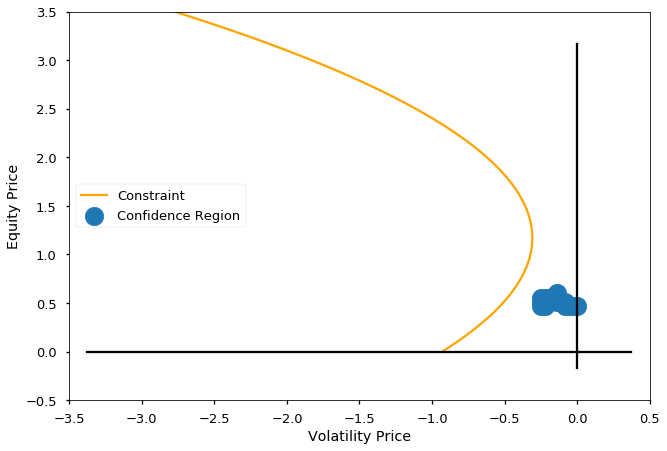

In [69]:
fig3, ax3 = mpl.pyplot.subplots()
ax3.scatter(y=accepted_vals.theta, x=accepted_vals.pi, marker='o', s=350, label='Confidence Region')
ax3.set_xlim([-3.5, .5])
ax3.set_ylim([-.5, 3.5])
yvals = np.linspace(0,5,100)
xvals = [constraint(omega['scale'], omega['psi'], omega['zeta'], x) for x in yvals]
ax3.plot(xvals, yvals, color='orange', label='Constraint')
ax3.axvline(0,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axvline(-15,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axhline(0,  xmin=.5 /16, xmax=1 - .5/16, color='black')
ax3.axhline(5,  xmin=.5 /16, xmax=1 - .5/16, color='black')
ax3.legend()
ax3.set_ylabel('Equity Price')
ax3.set_xlabel('Volatility Price')
# ax3.set_ylim([-0.1, 1.1])
# ax3.set_xlim([-1.1, 0.1])

fig3.savefig('../doc/figures/confidence_region.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

In [56]:
accepted_vals.min()

phi     -0.300000
pi      -0.250000
theta    0.466667
dtype: float64

In [57]:
accepted_vals.max()

phi     -0.2
pi       0.0
theta    0.6
dtype: float64